# Youtube data analysis
Analisaremos la informacion de youtube en Gran Breta;a analysis

## Set Up
### Importar Librerias

In [1]:
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install --upgrade geopandas
# Install descartes - Geopandas requirment
!pip install descartes 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 2,288 kB of archives.
After this operation, 13.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-gdal amd64 2.2.3+dfsg-2 [346 kB]
Fetched 2,288 kB in 1s (1,574 kB/s)
Selecting previously unselected

In [42]:
import os
import csv
import json

import numpy as np
import pandas as pd
import geopandas as gpd
%matplotlib inline

import seaborn as sns
import scipy.stats as stats
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import  GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [3]:
_mapbox_token = 'pk.eyJ1IjoidTIwMTcyNDQyMyIsImEiOiJjbDN2eHZpaDgwMHdrM2txcHd5YzlwempxIn0.iDkPaJgRqFMJjiBW8_gVEQ'

px.set_mapbox_access_token(_mapbox_token)

### Hoja de estilos

In [4]:
pd.options.display.float_format = '{:.2f}'.format # format floats to 2 decimal places in output

sns.set(style="ticks")
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')


### Cargar datos

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/thavs-college-repos/eb-2022-1-cc51/main/data/GBvideos_cc50.csv', quotechar='"')

### Inspeccionar los datos

In [6]:
# Ver las primeras columnas de datos
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,state,lat,lon,geometry
0,Jw1Y-zhQURU,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,26,2017-11-10T07:38:29.000Z,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...,Devon,50.70,-3.53,POINT (-3.529950197 50.70040529)
1,3s1rvMFUweQ,17.14.11,Taylor Swift: …Ready for It? (Live) - SNL,Saturday Night Live,24,2017-11-12T06:24:44.000Z,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",1053632,25561,2294,2757,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,False,False,False,Musical guest Taylor Swift performs …Ready for...,Manchester,53.50,-2.25,POINT (-2.247987103 53.50041526)
2,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787420,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...,Bath And North East Somerset,51.38,-2.35,POINT (-2.350022218 51.3837486)
3,PUTEiSjKwJU,17.14.11,Goals from Salford City vs Class of 92 and Fri...,Salford City Football Club,17,2017-11-13T02:30:38.000Z,"Salford City FC|""Salford City""|""Salford""|""Clas...",27833,193,12,37,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg,False,False,False,Salford drew 4-4 against the Class of 92 and F...,Aberdeen,57.17,-2.08,POINT (-2.079987021 57.17039797)
4,rHwDegptbI4,17.14.11,Dashcam captures truck's near miss with child ...,Cute Girl Videos,25,2017-11-13T01:45:13.000Z,[none],9815,30,2,30,https://i.ytimg.com/vi/rHwDegptbI4/default.jpg,False,False,False,Dashcam captures truck's near miss with child ...,Southampton,50.90,-1.40,POINT (-1.399976849 50.90003135)


In [7]:
# Informacion del dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38916 entries, 0 to 38915
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   video_id                38916 non-null  object 
 1   trending_date           38916 non-null  object 
 2   title                   38916 non-null  object 
 3   channel_title           38916 non-null  object 
 4   category_id             38916 non-null  int64  
 5   publish_time            38916 non-null  object 
 6   tags                    38916 non-null  object 
 7   views                   38916 non-null  int64  
 8   likes                   38916 non-null  int64  
 9   dislikes                38916 non-null  int64  
 10  comment_count           38916 non-null  int64  
 11  thumbnail_link          38916 non-null  object 
 12  comments_disabled       38916 non-null  bool   
 13  ratings_disabled        38916 non-null  bool   
 14  video_error_or_removed  38916 non-null

Podemos ver que el dataset tiene `38.916` elementos. Y tambien se evidencia que todas las columnas estan completas a excepcion de la `description` pues muestra `38.304` valores. 

In [8]:
# Visualizar la informacion estadistica del dataframe
df.describe()

,category_id,views,likes,dislikes,comment_count,lat,lon
count,38916.00,38916.00,38916.00,38916.00,38916.00,38916.00,38916.00
mean,16.83,5911943.63,134519.55,7612.56,13088.35,53.38,-2.38
std,7.75,19001209.95,349989.31,50956.83,50667.40,2.04,2.10
min,1.00,851.00,0.00,0.00,0.00,50.13,-7.33
25%,10.00,251527.25,5897.00,200.00,679.00,51.50,-3.53
50%,20.00,981889.00,25182.50,821.00,2478.00,53.20,-2.18
75%,24.00,3683628.50,114089.25,3357.50,9241.50,54.88,-1.08
max,43.00,424538912.00,5613827.00,1944971.00,1626501.00,58.97,1.30


Podemos analizar en esta tabla:
* En promedio un video en trending tiene `5.911.943` vistas. La media para la vistas es `981.889` es decir, el 50% de los videos tienen mas de este valor y el otro tiene menos. 
* El promedio de comentarios en estos video son `13.088` y la media es `2.478` 
* En promedio videos en tendencias tienen en promedio `134.519` me gustas y `7.612` no me gusta.

## Pre-procesar los datos

### Modificar valores vacios

Como mostramos previamente, la columna `description` contiene algunos valores nulos. Por ello debemos verificar y limpiar estas columnas antes de analizar el dataset. 

In [9]:
df[df["description"].apply(lambda x: pd.isna(x))].head(2)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,state,lat,lon,geometry
91,_wM_jY_rass,17.14.11,Bone on Labour HQ,Ross Kempsell,25,2017-11-06T16:12:58.000Z,[none],159065,1160,1164,0,https://i.ytimg.com/vi/_wM_jY_rass/default.jpg,True,False,False,NaN,Bristol,51.45,-2.58,POINT (-2.583315472 51.44999778)
118,8HON4AswPVk,17.14.11,Arvo Pärt - Tabula Rasa,JSaxofone,10,2012-09-13T12:35:46.000Z,"Arvo|""Pärt""|""Tabula""|""Rasa""|""part""|""violin""|""c...",728177,4007,71,240,https://i.ytimg.com/vi/8HON4AswPVk/default.jpg,False,False,False,NaN,Dungannon,54.52,-6.67,POINT (-6.670016929 54.52037884)


Para no dejar estos valores como `NA`, es mejor cambiar estoys valores a cadenas vacias.

In [10]:
df["description"] = df["description"].fillna(value="") # Fillna con vacio

### Completar informacion de categorias

Antes de analizar los datos y para facilitar la visualizacion de datos, uniremos los valores de `category_id` con su representacion en el archivo `GB_category_id.json`. De esta forma no podremos colocar numbero en lugar

In [11]:
df['category_id'].head(2)

0    26
1    24
Name: category_id, dtype: int64

In [12]:
with open("data/GB_category_id.json") as f:
    categories = json.load(f)["items"]
    
cat_dict = {}
for cat in categories:
    cat_id = int(cat["id"])
    cat_dict[cat_id] = cat["snippet"]["title"]
    
df['category_name'] = df['category_id'].map(cat_dict)

### Modificar tipos
Modificar los tipos de las fechas a 

In [13]:
df['publish_hour'] = pd.to_datetime(df["publish_time"]).dt.time
df['publish_time'] = pd.to_datetime(df["publish_time"]).dt.date
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%M').dt.date


## Visualizar los datos


### **Por Categorias de Videos**
#### 1) ¿Qué categorías de videos son las de mayor tendencia?

In [14]:
cdf = df["category_name"].value_counts().to_frame().reset_index()
cdf.rename(columns={"index": "category_name", "category_name": "No_of_videos"}, inplace=True)
cdf.head()

,category_name,No_of_videos
0,Music,13754
1,Entertainment,9124
2,People & Blogs,2926
3,Film & Animation,2577
4,Howto & Style,1928


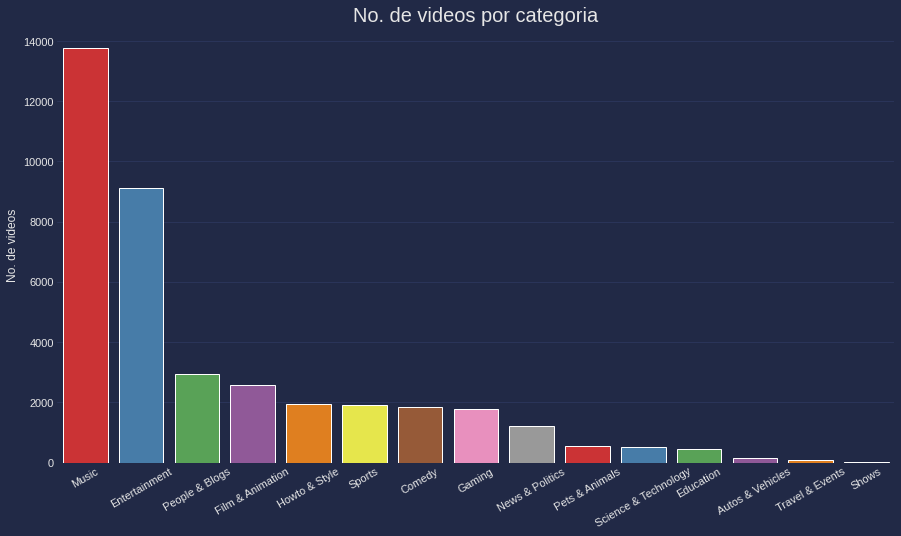

<Figure size 1008x1440 with 0 Axes>

In [15]:
fig, ax = plt.subplots()
plt.figure(figsize = (14,20))
_ = sns.barplot(x="category_name", y="No_of_videos", data=cdf, ax=ax, palette="Set1")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
_ = ax.set(xlabel="", ylabel="No. de videos")
_ = ax.set_title("No. de videos por categoria", fontsize=20)

fig.set_size_inches(15, 8, forward=True)


Descripción: Es claro que la categoría de Música es la que tiene la mayor cantidad de videos en tendencias. Casi `14.000` videos en tendencias. Le sigue la categoría de Entretenimiento con unos `9.000` vídeos. Se evidencia que estas dos categorías contienen más del `50%` de todos los videos en tendencias. 

#### 2) ¿Qué categorías de videos son los que más gustan? ¿Y las que menos gustan?
Debido a la variabilidad de los likes y dislikes en un video en relación a otro, primero crearemos un nuevo df con dos nuevas columnas que nos ayudarán a visualizar mejor la data. Las columnas `likes_dis` and `dislikes_dis` tendrán los valores de likes y dislikes como distribuciones normales para así visualizar mejor la data.

In [16]:
cld_df = df[['category_name']].copy()
cld_df['dislikes_dis'] = np.log(df['dislikes'] + 1)
cld_df['likes_dis'] = np.log(df['likes'] + 1)

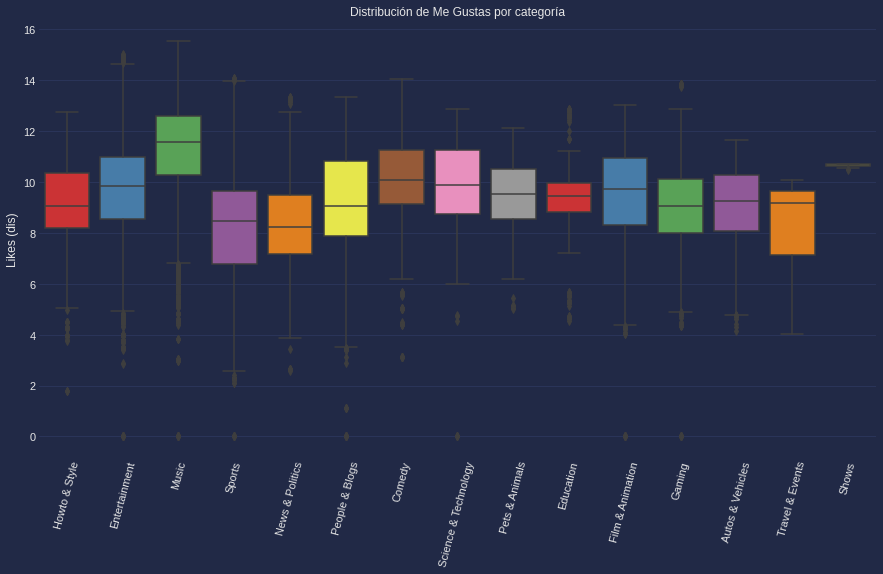

<Figure size 1008x1440 with 0 Axes>

In [17]:
# Me gustas lik
fig, ax = plt.subplots()
plt.figure(figsize = (14,20))

g = sns.boxplot(x='category_name', y='likes_dis', data=cld_df, palette="Set1", ax=ax)
_ = ax.set(xlabel="", ylabel="Likes (dis)", title="Distribución de Me Gustas por categoría")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
fig.set_size_inches(15, 8, forward=True)

plt.show()

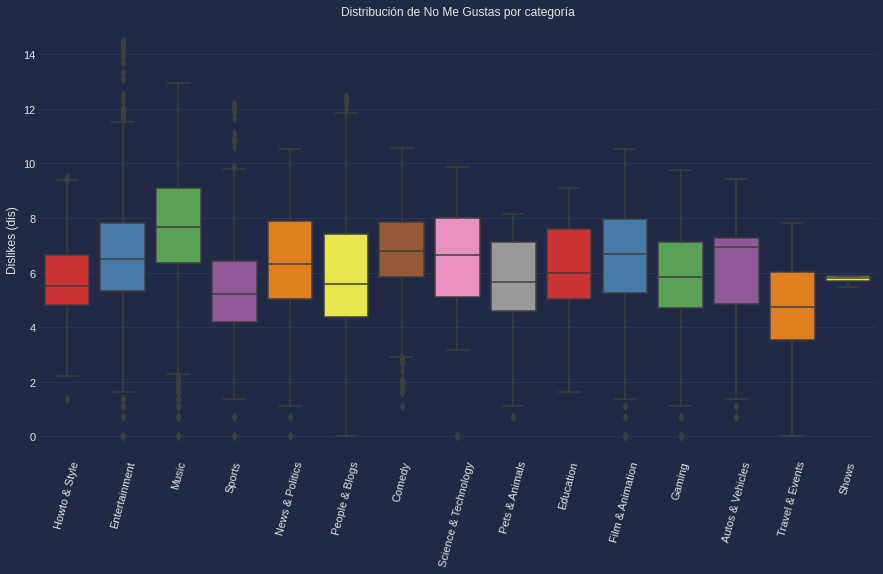

<Figure size 1008x1440 with 0 Axes>

In [18]:
# Me gustas lik
fig, ax = plt.subplots()
plt.figure(figsize = (14,20))

g = sns.boxplot(x='category_name', y='dislikes_dis', data=cld_df, palette="Set1", ax=ax)
_ = ax.set(xlabel="", ylabel="Dislikes (dis)", title="Distribución de No Me Gustas por categoría")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
fig.set_size_inches(15, 8, forward=True)


Por un lado, se evidencia que la categoría de `Música` es la que tiene la mayor cantidad de me gustas y parece ser la que más gusta, del mismo modo, es la categoría con la mayor cantidad de no me gustas. Debido al análisis anterior es entendible que a esta ser la categoría con el mayor número de video en tendencias tenga el mayor número de interacciones y valores outliers. 

Por otro lado, la categoría de `Entretenimiento` tiene la mayor cantidad de valores de no me gusta fuera del rango promedio. Es decir, a pesar de que la mayoría de los videos se encuentran en un rango estable de no me gustas, los videos menos gustados en este dataset de tendencia se encuentran en esta categoría. 

#### 3) ¿Qué categorías de videos tienen la mejor proporción (ratio) de “Me gusta” / “No me gusta”?

Debido a la variabilidad de los likes y dislikes en un video en relación a otro, primero crearemos un nuevo df con dos n uevas columnas que recolectaran la data del ratio por columna de la categoria, que sera representada por los me gusta y los no me gusta

In [19]:
rld_df = df[['category_name']].copy()
rld_df['likes'] = ((df.isnull().sum() / len(df))*100).sort_values(ascending = False)
rld_df['dislikes'] = ((df.isnull().sum() / len(df))*100).sort_values(ascending = False)

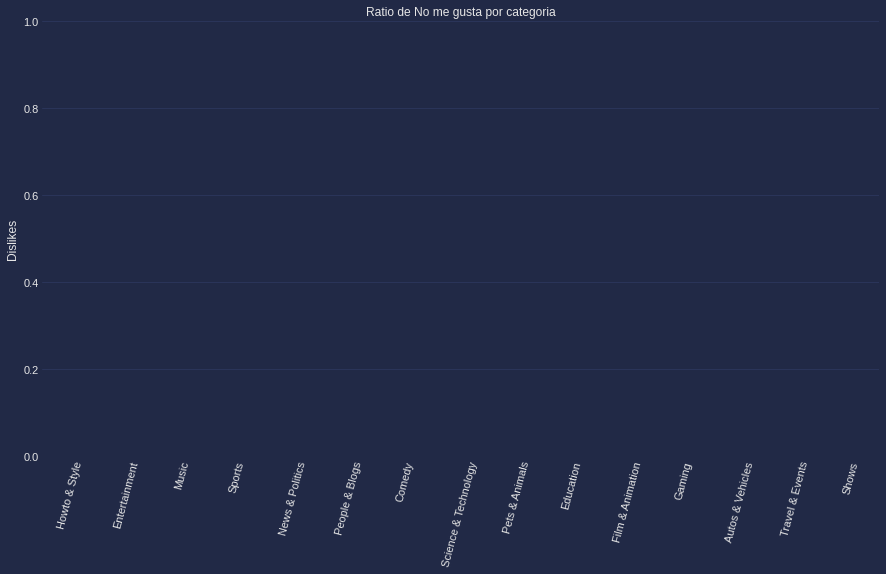

<Figure size 1008x1440 with 0 Axes>

In [23]:
fig, ax = plt.subplots()
plt.figure(figsize = (14,20))

g = sns.boxplot(x='category_name', y='dislikes', data=rld_df, palette="Set1", ax=ax)
_ = ax.set(xlabel="", ylabel="Dislikes" , title="Ratio de No me gusta por categoria")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
fig.set_size_inches(15, 8, forward=True)

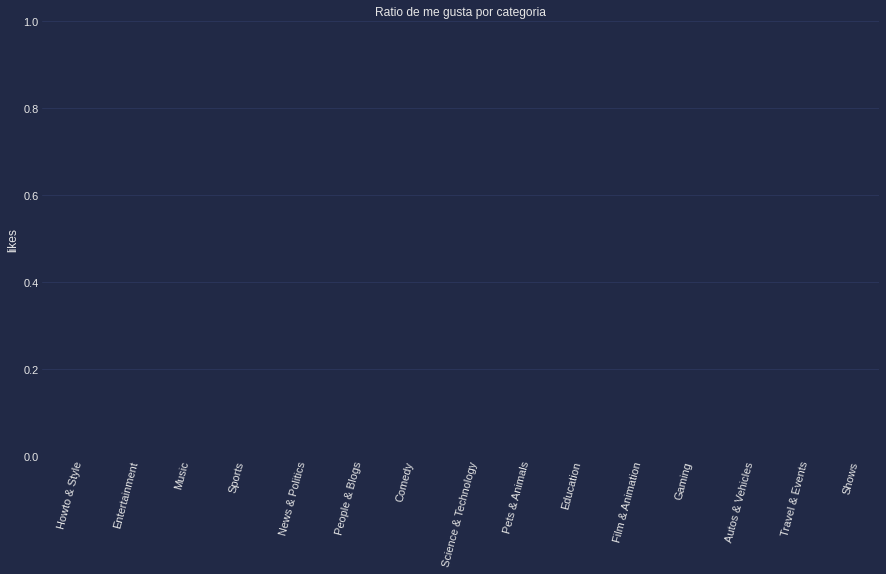

<Figure size 1008x1440 with 0 Axes>

In [25]:
fig, ax = plt.subplots()
plt.figure(figsize = (14,20))

g = sns.boxplot(x='category_name', y='likes', data=rld_df, palette="Set1", ax=ax)
_ = ax.set(xlabel="", ylabel="likes" , title="Ratio de me gusta por categoria")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
fig.set_size_inches(15, 8, forward=True)

Como se puede apreciar en el grafico , el que tiene mayor proporcion por categoria de videos , son los Me gustas , esto debido al contenido que de las diversas categorias .

#### 4) ¿Qué categorías de videos tienen la mejor proporción (ratio) de “Vistas” / “Comentarios”?

Debido a la variabilidad de los likes y dislikes en un video en relación a otro, primero crearemos un nuevo df con dos n uevas columnas que recolectaran la data del ratio por columna de la categoria, que sera representada por los me vistas y los comentarios

In [26]:
rld_df = df[['category_name']].copy()
rld_df['views'] = ((df.isnull().sum() / len(df))*100).sort_values(ascending = False)
rld_df['comment_count'] = ((df.isnull().sum() / len(df))*100).sort_values(ascending = False)

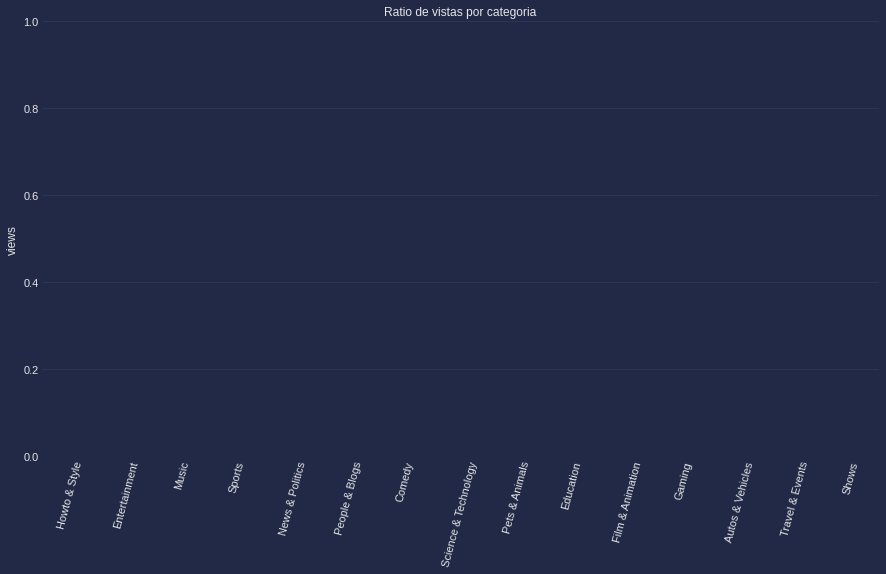

<Figure size 1008x1440 with 0 Axes>

In [28]:
fig, ax = plt.subplots()
plt.figure(figsize = (14,20))

g = sns.boxplot(x='category_name', y='views', data=rld_df, palette="Set1", ax=ax)
_ = ax.set(xlabel="", ylabel="views" , title="Ratio de vistas por categoria")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
fig.set_size_inches(15, 8, forward=True)

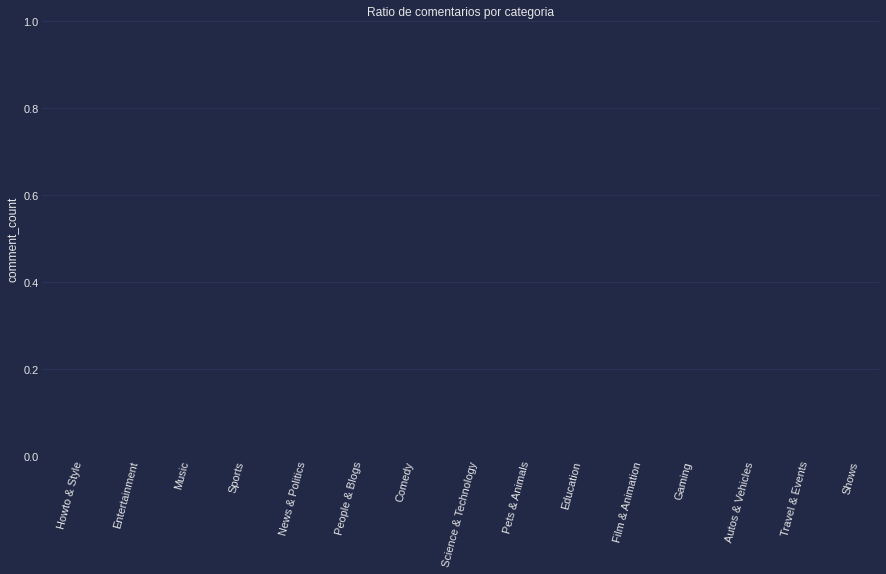

<Figure size 1008x1440 with 0 Axes>

In [30]:
fig, ax = plt.subplots()
plt.figure(figsize = (14,20))

g = sns.boxplot(x='category_name', y='comment_count', data=rld_df, palette="Set1", ax=ax)
_ = ax.set(xlabel="", ylabel="comment_count" , title="Ratio de comentarios por categoria")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
fig.set_size_inches(15, 8, forward=True)

Como se puede apreciar en el grafico , el que tiene mayor proporcion por categoria de videos , son las vistas , ya que dependiendo del contenido de la categoria los usuarios comentan si fue o no su agrado de la categoria

### **Por el tiempo transcurrido**

#### 5) ¿Cómo ha cambiado el volumen de los videos en tendencia a lo largo del tiempo?

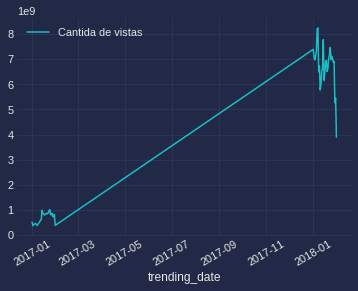

In [31]:
#by_time = df.groupby("trending_date")
df2 = df.groupby('trending_date')['views'].sum().plot(legend=True,rot=30)
plt.legend(["Cantida de vistas"]);

Aquí se puede apreciar la cantidad de vistas en cantidades elevadas ala 9, como escala.
Podemos ver como incrementa el volumen de vistas mientras el tiempo(fechas) avanzan, y al final tiende a hacer una curva oscílente. A continuación le haremos un Zoom para ver su comportamiento, para esto elegiremos las fechas de auge y lo ordenaremos de mayor a menor



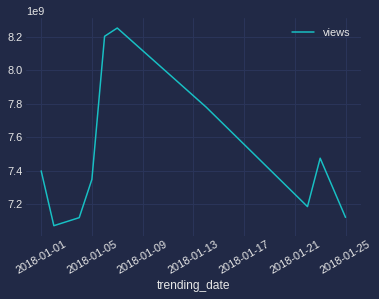

In [32]:
df2 = df.groupby('trending_date')['views'].sum().nlargest(10).plot(legend=True,rot=30)

Si ordenaramos a los que mayores vistas tiene de mayor a menor vemos la fecha de su auje y como fue disminuyendo descendientemente, (se estan mostrando los 10 primeros)

### **Por Canales de YouTube**

#### 6) ¿Qué Canales de YouTube son tendencia más frecuentemente? ¿Y cuáles con menos frecuencia?

In [35]:
by_chane = df['channel_title'].value_counts().to_frame().reset_index()
by_chane.rename(columns={"index": "Canal", "channel_title": "Cantidad de videos"}, inplace=True)
by_chane.head()

,Canal,Cantidad de videos
0,The Tonight Show Starring Jimmy Fallon,208
1,Jimmy Kimmel Live,207
2,TheEllenShow,207
3,Saturday Night Live,206
4,WWE,205


Como vemos Este es el DataFrame de los canales con más videos en tendencia, y como se puede apreciar el canal "The Tonight Show Starring Jimmy Fallon" es el que anda liderando con 208 videos en tendencia, para lograr esto se realizó un groupby en "canal" y un count del mismo (cantidad de videos en tendencia)

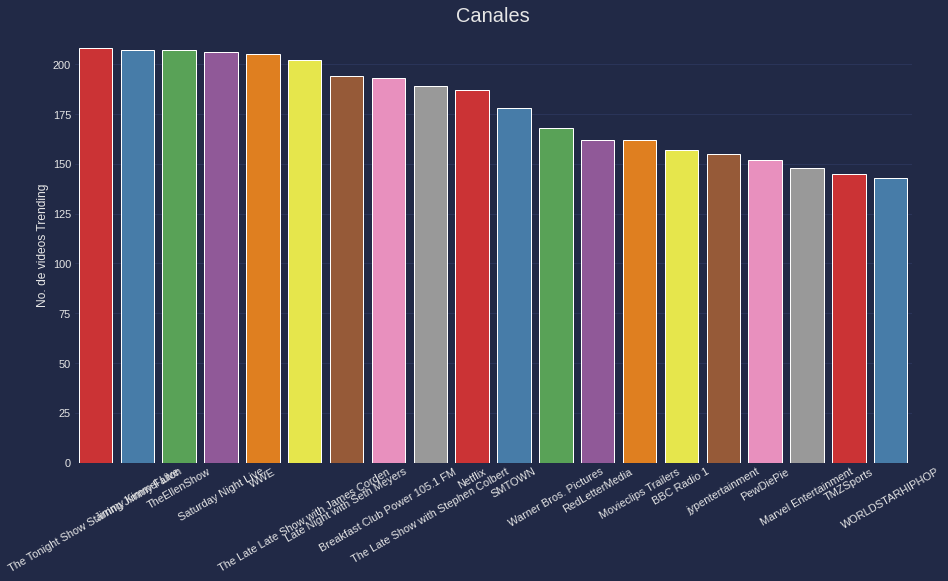

<Figure size 1008x1440 with 0 Axes>

In [36]:
fig, ax = plt.subplots()
plt.figure(figsize = (14,20))
_ = sns.barplot(x="Canal", y="Cantidad de videos", data=by_chane[:20], ax=ax, palette="Set1")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
_ = ax.set(xlabel="", ylabel="No. de videos Trending")
_ = ax.set_title("Canales", fontsize=20)

fig.set_size_inches(15, 8, forward=True)

Aquí lo podemos observar en un gráfico de barras, con la misma información del DataFrame

### **Por la geografía del país**


#### 7) ¿En qué Estados se presenta el mayor número de “Vistas”, “Me gusta” y “No me gusta”?

In [37]:
g_map = df.groupby(["state", "lon", "lat"])


views_map = g_map['views'].sum().reset_index() 
likes_map = g_map['likes'].sum().reset_index() 
dislikes_map = g_map['dislikes'].sum().reset_index() 

##### Vistas

In [38]:
fig = px.scatter_mapbox(views_map, lat="lat", lon="lon", zoom=4, height=450, 
                        color="views", hover_name="state", size="views", size_max=25,
                        color_continuous_scale=px.colors.sequential.Rainbow
                      )

print( views_map.sort_values(by=['views'], ascending=False).head() )
print( views_map.sort_values(by=['views']).head(2) )

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

               state   lon   lat       views
39       Southampton -1.40 50.90  5570080346
0           Aberdeen -2.08 57.17  5482827742
41  Stockton On Tees -1.23 54.58  5458518084
38   South Yorkshire -1.50 53.37  5448546504
46     West Midlands -1.50 52.42  5368026416
         state   lon   lat       views
2      Belfast -5.96 54.60  3532467750
26  Merseyside -2.92 53.42  3646696350


En el gráfico se puede visualizar que existen tres zonas que se acercan a los `5.5B` de visitas. El estado con el mayor número de vistas es `Southampton` con `5.570.080.346` de vistas y el segundo con el mayor número es `Aberdeen` con `5.482.827.742`. Los estados con menos vistas son `Belfast` y `Merseyside` respectivamente.  

##### Me gustas

In [39]:
fig = px.scatter_mapbox(likes_map, lat="lat", lon="lon", zoom=4, height=450, 
                        color="likes", hover_name="state", size="likes", size_max=25,
                        color_continuous_scale=px.colors.sequential.Rainbow
                      )

print( likes_map.sort_values(by=['likes'], ascending=False).head() )
print( likes_map.sort_values(by=['likes']).head(2) )

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

                     state   lon   lat      likes
38         South Yorkshire -1.50 53.37  132686060
46           West Midlands -1.50 52.42  121579342
23               Leicester -1.13 52.63  121366689
12                   Devon -3.53 50.70  120366933
33  Perthshire And Kinross -3.47 56.40  119876590
      state   lon   lat     likes
2   Belfast -5.96 54.60  84331627
31    Omagh -7.30 54.60  85009092


En este gráfico se evidencia aún más claramente la zona con la mayor cantidad de Me gustas es `South Yorkshire` con más de `130M` de Me gustas le sigue después `West Midlands` con `121M`. Las regiones que menos interactuaron con el Me gusta fueron Belfast` y `Omagh`.

##### No Me Gusta

In [40]:
fig = px.scatter_mapbox(dislikes_map, lat="lat", lon="lon", zoom=4, height=450, 
                        color="dislikes", hover_name="state", size="dislikes", size_max=25,
                        color_continuous_scale=px.colors.sequential.Rainbow
                      )

print( dislikes_map.sort_values(by=['dislikes'], ascending=False).head() )
print( dislikes_map.sort_values(by=['dislikes']).head(2) )

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

                           state   lon   lat  dislikes
1   Bath And North East Somerset -2.35 51.38  12622353
39                   Southampton -1.40 50.90   8617820
38               South Yorkshire -1.50 53.37   8451143
19                    Inverclyde -4.75 55.93   8390226
17                       Glasgow -4.25 55.87   8385133
         state   lon   lat  dislikes
7      Cardiff -3.23 51.50   3906929
26  Merseyside -2.92 53.42   3910656


Pocas regiones interactúan con el botón de No Me Gusta pero entre todas destaca `Bath And North East Somerset` con una gran cantidad de No Me Gustas en relación al resto de los estados. Exactamente la diferencia entre el primero y el segundo estado es de más de `4M` de No Me Gustas. 

### Adicionalmente, al cliente le gustaría conocer si:

#### ¿Es factible predecir el número de “Vistas” o “Me gusta” o “No me gusta”?

In [41]:
dfs=df.sort_values(by=['views'], ascending=False)
dfs[['views','likes','dislikes']]

,views,likes,dislikes
28412,424538912,2818771,149275
28212,413586699,2768654,145643
28008,402650804,2719005,142006
27811,392036878,2670723,138334
27615,382401497,2618320,134625
...,...,...,...
4342,972,13,0
4113,937,13,0
3908,922,13,0
3701,890,13,0


:Se asume que la cantidad de “Vistas” o “Me gusta” o “No me gusta” , depende de la popularidad del video 

In [ ]:
mask = (df['views'] >= df['likes'])
df[['likes','dislikes']]
dfa = df[df['likes'] > df['dislikes']]
dfb[['views','likes','dislikes']]

,views,likes,dislikes
91,159065,1160,1164
309,160381,1168,1170
1183,161542,1173,1174
1390,161624,1173,1174
6237,194417,603,4732
6418,708489,3960,54062
6450,197887,619,4765
6622,753386,4167,57285
6655,199235,621,4779
6831,773421,4234,58327


No es factible predecir la cantidad de "vistas" , "me gusta", "no me gusta" , de un video porque el factor puede variar dependiendo del contenido del video , algunos pueden tener mayor vistas y tener mas "no me gusta" de lo que un video de menor vistas pueda tener mayor "me gustas"

#### ¿Los videos en tendencia son los que mayor cantidad de comentarios positivos reciben?

Se asume que la cantidad de comentarios negativos se da cuando hay un alto número de dislikes (más alto que el de los likes), que los comentarios fueron deshabilitados o que se deshabilitaron la calificación por rating

In [ ]:
dfs=df.sort_values(by=['views'], ascending=False)
dfs[['views','likes','dislikes','comments_disabled','ratings_disabled']]

,views,likes,dislikes,comments_disabled,ratings_disabled
28412,424538912,2818771,149275,False,False
28212,413586699,2768654,145643,False,False
28008,402650804,2719005,142006,False,False
27811,392036878,2670723,138334,False,False
27615,382401497,2618320,134625,False,False
...,...,...,...,...,...
4342,972,13,0,False,False
4113,937,13,0,False,False
3908,922,13,0,False,False
3701,890,13,0,False,False


Como se puede ver los videos con mayores views que son los que mas en tendencia estan no tienen ese comportamiento

In [ ]:
mask = (df['likes'] >= df['dislikes'])
df[['likes','dislikes']]
dfa = df[df['likes'] < df['dislikes']]
dfb = dfa[df['comments_disabled']==True]
'''
Notas del editor:
  se usaria "DFC" pero como se ve en el resultado no hay valores con True en nuestro filtrado
'''
dfc = dfb[df['ratings_disabled']==True]
dfb[['views','likes','dislikes','comments_disabled','ratings_disabled']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,views,likes,dislikes,comments_disabled,ratings_disabled
91,159065,1160,1164,True,False
309,160381,1168,1170,True,False
1183,161542,1173,1174,True,False
1390,161624,1173,1174,True,False
6237,194417,603,4732,True,False
6418,708489,3960,54062,True,False
6450,197887,619,4765,True,False
6622,753386,4167,57285,True,False
6655,199235,621,4779,True,False
6831,773421,4234,58327,True,False


Como se puede ver no necesariamente los videos con mayores views o que mas tendencia marcan son los que tienen comentarios negativos


### **Approach 2 Metodo de aprendizaje automatico con boosting**

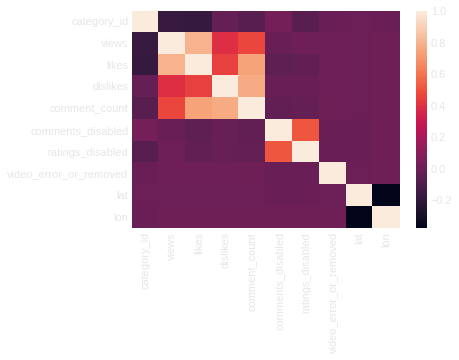

In [47]:
sns.heatmap(df.corr())

In [48]:
X = df[['likes','dislikes','views','comment_count']]
y = df['comments_disabled']

In [49]:
X = X.to_numpy()

In [50]:
X[0:5]

array([[   55681,    10247,  7224515,     9479],
       [   25561,     2294,  1053632,     2757],
       [  787420,    43420, 17158579,   125882],
       [     193,       12,    27833,       37],
       [      30,        2,     9815,       30]])

In [51]:
y = y.to_numpy()

In [52]:
y[0:5]

array([False, False, False, False, False])

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [54]:
X_train[0:5]

array([[    327,      27,   28872,      38],
       [  12159,     439,  239848,     931],
       [  31727,     543, 1860859,    1231],
       [  12065,     352,  216784,    2723],
       [   8251,     917, 1689988,    1374]])

In [55]:
X_test[0:5]

array([[    5103,      370,   328693,      946],
       [   73280,     1771,  2038158,     8539],
       [    4827,      305,   377945,     1182],
       [   36571,     3715,   555962,    13827],
       [ 1642648,    52596, 71173287,   108846]])

In [56]:
X_train_orig = X_train
X_test_orig = X_train

In [57]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [58]:
X_train[0:5]

array([[-0.37933956, -0.14401135, -0.30856688, -0.25501804],
       [-0.34582583, -0.13626307, -0.29748071, -0.23761812],
       [-0.29040014, -0.13430719, -0.21230132, -0.23177269],
       [-0.34609208, -0.13789924, -0.29869265, -0.20270138],
       [-0.35689511, -0.12727356, -0.22128009, -0.22898636]])

In [59]:
X_test[0:5]

array([[-0.38667966, -0.17002388, -0.29799315, -0.25005331],
       [-0.1846428 , -0.13577333, -0.20745953, -0.09172066],
       [-0.38749756, -0.17161295, -0.29538475, -0.24513214],
       [-0.29342686, -0.08824794, -0.28595693,  0.01854709],
       [ 4.46604859,  1.10675647,  3.45395123,  1.99992604]])

In [60]:
#Validación Cruzada
cv_scores = cross_val_score(GradientBoostingClassifier(),X_train,y_train,cv=5)

In [61]:
#Accuracy
print(cv_scores)

[0.99967882 0.99967882 0.99951815 0.99967877 0.99967877]


In [63]:
#Tuning
#n_estimators: Número de árboles
#max_features: Cantidad de variables a considerar al buscar el mejor split
#max_depth: Profundidad del árbol

param_grid = {
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]
}

In [64]:
grid = GridSearchCV(GradientBoostingClassifier(),param_grid,refit=True,verbose=2,cv=5)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END ...max_depth=2, max_features=auto, n_estimators=200; total time=   5.3s
[CV] END ...max_depth=2, max_features=auto, n_estimators=200; total time=   6.9s
[CV] END ...max_depth=2, max_features=auto, n_estimators=200; total time=   6.9s
[CV] END ...max_depth=2, max_features=auto, n_estimators=200; total time=   8.1s
[CV] END ...max_depth=2, max_features=auto, n_estimators=200; total time=   7.4s
[CV] END ...max_depth=2, max_features=auto, n_estimators=700; total time=  23.0s
[CV] END ...max_depth=2, max_features=auto, n_estimators=700; total time=  19.0s
[CV] END ...max_depth=2, max_features=auto, n_estimators=700; total time=  18.9s
[CV] END ...max_depth=2, max_features=auto, n_estimators=700; total time=  18.8s
[CV] END ...max_depth=2, max_features=auto, n_estimators=700; total time=  26.0s
[CV] END ...max_depth=2, max_features=sqrt, n_estimators=200; total time=   4.7s
[CV] END ...max_depth=2, max_features=sqrt, n_e

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 700]},
             verbose=2)

In [65]:
print(grid.best_estimator_)

GradientBoostingClassifier(max_features='auto', n_estimators=700)


In [66]:
#Boosting
classifier = GradientBoostingClassifier(max_depth=2, max_features='log2', n_estimators=200).fit(X_train, y_train)

In [68]:
feature_scores = pd.Series(classifier.feature_importances_, index=['likes','dislikes','views','comment_count']).sort_values(ascending=False)
feature_scores

comment_count   0.71
likes           0.25
views           0.02
dislikes        0.02
dtype: float64

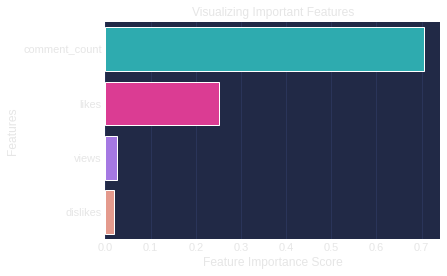

In [69]:
sns.barplot(x=feature_scores, y=feature_scores.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [70]:
y_pred = classifier.predict(X_test)

In [71]:
y_pred[0:20]

array([False, False, False, False, False,  True, False, False, False,
        True, False, False, False, False, False, False,  True, False,
       False, False])

In [72]:
y_test[0:20]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [73]:
confusion_matrix(y_test, y_pred)

array([[6647, 1006],
       [  12,  119]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



Confusion matrix, without normalization
[[6647 1006]
 [  12  119]]
Normalized confusion matrix
[[0.86854828 0.13145172]
 [0.09160305 0.90839695]]


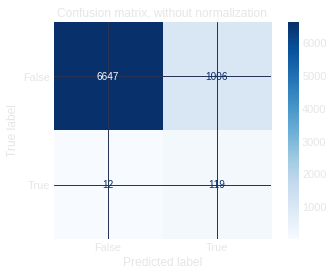

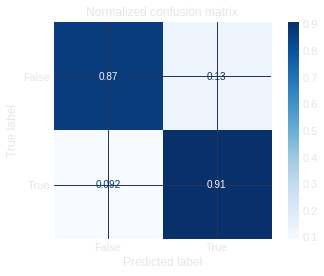

In [74]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 #display_labels=y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [75]:
y_pred_prob = classifier.predict_proba(X_test)

In [76]:
y_pred_prob[0:5]

array([[9.99986470e-01, 1.35295007e-05],
       [9.99998323e-01, 1.67664983e-06],
       [9.99986470e-01, 1.35295007e-05],
       [9.99998901e-01, 1.09909688e-06],
       [9.99999191e-01, 8.09346538e-07]])

In [78]:
y_pred_prob[0:5,1]

array([1.35295007e-05, 1.67664983e-06, 1.35295007e-05, 1.09909688e-06,
       8.09346538e-07])

In [79]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_prob[:,1])

In [80]:
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.940745683726284

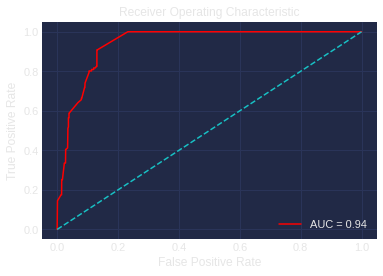

In [81]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()